In [1]:
#Load Libraries
import numpy as np            
import pandas as pd           
import matplotlib.pyplot as plt  
import scipy                  
import filterpy

%matplotlib inline

In [2]:
## Define Functions

In [5]:
import pandas as pd

def read_data():
    accel_data = pd.read_csv('.//2023-11-17-15-11-06//accel-0.csv')
    gps_time_data = pd.read_csv('.//2023-11-17-15-11-06//gps_time.csv')
    gps_visibility_data = pd.read_csv('.//2023-11-17-15-11-06//gps_visibility.csv')
    gps_data = pd.read_csv('.//2023-11-17-15-11-06//gps-0.csv')
    gyro_data = pd.read_csv('.//2023-11-17-15-11-06//gyro-0.csv')
    mag_data = pd.read_csv('.//2023-11-17-15-11-06//mag-0.csv')
    time_data = pd.read_csv('.//2023-11-17-15-11-06//time.csv')
    
    return accel_data, gps_time_data, gps_visibility_data, gps_data, gyro_data, mag_data, time_data

In [3]:
#Calculate Orientation

def calculate_orientation(a_x, a_y, a_z, previous_pitch, previous_roll):
    
    alpha = 0.9999
    
    theta_z = np.arctan2(a_y, a_z)
    theta_x = np.arctan2(a_x, np.sqrt(a_y**2 + a_z**2))
    pitch = (previous_pitch * alpha) + (theta_x * (1 - alpha))
    roll = (previous_roll * alpha) + (theta_z * (1 - alpha))
    
    return pitch, roll

In [4]:
#Calculate Velocity

def calculate_velocity(a_x, a_y, a_z, previous_velocity_x, previous_velocity_y, previous_velocity_z, delta_t):
    
    velocity_x = previous_velocity_x + a_x * delta_t
    velocity_y = previous_velocity_y + a_y * delta_t
    velocity_z = previous_velocity_z + a_z * delta_t
    
    return velocity_x, velocity_y, velocity_z

In [7]:
#Calculate Position

def calculate_position(previous_position_x, previous_position_y, velocity_x, velocity_y, delta_t):
    
    position_x = previous_position_x + velocity_x * delta_t
    position_y = previous_position_y + velocity_y * delta_t

    return position_x, position_y

In [39]:
# Create Rotation Matrix

def create_rotation_matrix(yaw):

    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[-c, -s], [-s, c]])  
    
    return R

In [29]:
from pykalman import KalmanFilter
import numpy as np

def run_kalman_filter(data_in, dt, var):
    # Initialize Kalman Filter parameters
    F = np.array([[1, dt, 0.5 * dt**2], [0, 1, dt], [0, 0, 1]])
    H = np.array([0, 0, 1])
    Q = np.array([[0.2, 0, 0], [0, 0.1, 0], [0, 0, 10e-4]])
    R = np.array([[var]])
    X0 = np.array([0, 0, data_in[0]])
    P0 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, var]])

    # Define the Kalman Filter
    kf = KalmanFilter(transition_matrices=F, observation_matrices=H, transition_covariance=Q, 
                      observation_covariance=R, initial_state_mean=X0, initial_state_covariance=P0)

    # Iterative estimation for each new measurement
    filtered_state_means = np.zeros((len(data_in), 3))
    for t in range(len(data_in)):
        if t == 0:
            filtered_state_means[t] = X0
        else:
            filtered_state_means[t], _ = kf.filter_update(
                filtered_state_means[t-1],
                P0,
                observation=data_in[t]
            )

    return filtered_state_means[:, 2]


In [37]:
def run_kalman_filter_with_transformation(accel_array, mag_data, dt, var):
    # Initialize arrays for filtered acceleration data
    filtered_accel_ned = np.zeros_like(accel_array)

    # Apply Kalman filter to each axis
    for i in range(3):  # For x, y, and z axes
        filtered_axis_data = run_kalman_filter(accel_array[:, i], dt, var)
        filtered_accel_ned[:, i] = filtered_axis_data

    # Transform acceleration data to NED frame
    for i in range(len(filtered_accel_ned)):
        yaw = calculate_yaw(mag_data['mag_x (uT)'].iloc[i], mag_data['mag_y (uT)'].iloc[i])
        R = create_rotation_matrix(yaw)

        # Apply rotation matrix to x and y components
        accel_body = filtered_accel_ned[i, :2]
        accel_ned = R @ accel_body
        filtered_accel_ned[i, :2] = accel_ned

    return filtered_accel_ned

In [10]:
# Calculate Heading

def calculate_heading(mag_x, mag_y):
    
    heading = np.arctan2(mag_x, mag_y)
    
    return np.degrees(heading)

In [11]:
# Calculate Yaw

def calculate_yaw(mag_x, mag_y):
    
    yaw = np.arctan2(mag_y, mag_x)
    
    return yaw

In [47]:
def calculate_position_with_gps_update(filtered_accel_ned, gps_data, imu_time, gps_time, delta_t):
    # Initialize variables
    prev_pos_x, prev_pos_y, prev_vel_x, prev_vel_y, prev_vel_z = 0, 0, 0, 0, 0

    positions_x, positions_y = [], []

    for i in range(len(filtered_accel_ned)):
        # Calculate orientation (implement this function as needed)
        #pitch, roll = calculate_orientation(filtered_accel_ned[i])

        # Calculate velocity
        velocity_x = prev_vel_x + filtered_accel_ned[i, 0] * delta_t
        velocity_y = prev_vel_y + filtered_accel_ned[i, 1] * delta_t
        velocity_z = prev_vel_z + filtered_accel_ned[i, 2] * delta_t

        # Calculate position
        pos_x = prev_pos_x + velocity_x * delta_t
        pos_y = prev_pos_y + velocity_y * delta_t

        # Check if GPS update is available
        #if imu_time[i] in gps_time:
            #gps_index = np.where(gps_time == imu_time[i])[0][0]
            # Update position with GPS data (convert GPS lat/lon to x/y coordinates)
            #pos_x, pos_y = convert_gps_to_xy(gps_data.iloc[gps_index])

        # Update previous values
        prev_pos_x, prev_pos_y = pos_x, pos_y
        prev_vel_x, prev_vel_y, prev_vel_z = velocity_x, velocity_y, velocity_z

        # Store positions
        positions_x.append(pos_x)
        positions_y.append(pos_y)

    # Convert positions to numpy arrays
    positions_x = np.array(positions_x)
    positions_y = np.array(positions_y)
    R = np.array([[0,1],
             [-1,0]])
    positions = np.vstack((positions_x, positions_y))
    positions_x, positions_y = R @ positions

    return positions_x, positions_y

In [13]:
import utm

def convert_gps_to_xy(gps_row):
    # Extract latitude and longitude
    lat = gps_row['gps_lat (deg)']
    lon = gps_row['gps_lon (deg)']

    # Convert to UTM coordinates
    utm_conversion = utm.from_latlon(lat, lon)
    x, y = utm_conversion[0], utm_conversion[1]

    return x, y


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import utm

def plot_data(imu_positions_x, imu_positions_y, ref_gps_data, filtered_accel_x, true_accel_x):
    # Convert GPS coordinates to UTM
    gps_lat = ref_gps_data['ref_gps_lat (deg)']
    gps_lon = ref_gps_data['ref_gps_lon (deg)']
    utm_coords = [utm.from_latlon(lat, lon) for lat, lon in zip(gps_lat, gps_lon)]
    utm_x = np.array([coord[0] for coord in utm_coords])
    utm_y = np.array([coord[1] for coord in utm_coords])

    # Assuming the first UTM coordinate is the origin for IMU data
    origin_x, origin_y = utm_x[0], utm_y[0]
    imu_positions_x = imu_positions_x + origin_x
    imu_positions_y = imu_positions_y + origin_y

    # Plot GPS and IMU data
    plt.figure(figsize=(16, 12))
    ax = plt.axes(projection='3d')
    plt.plot(utm_x, utm_y, label='GPS Path', linestyle='-', color='black')
    plt.plot(imu_positions_x, imu_positions_y, label='Calculated IMU Position', linestyle='-', color='red')
    plt.xlabel('East (m)')
    plt.ylabel('North (m)')
    plt.title('GPS and IMU Path Comparison')
    plt.legend()
    plt.show()

    # Calculate and print the average acceleration error
    acceleration_error = np.abs(filtered_accel_x - true_accel_x)
    average_error = np.mean(acceleration_error)
    print(f"Average Acceleration Error: {average_error:.3f} m/s^2")

    true_positions = np.column_stack((utm_x, utm_y))
    estimated_positions = np.column_stack((imu_positions_x, imu_positions_y))
    distance_away = np.mean(true_positions[-1] - estimated_positions[-1])
    print(f"Final Distance Away from True Position: {distance_away:.3f} m")
    

# Run Code

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm
from pykalman import KalmanFilter
%matplotlib widget

In [19]:
accel_data, gps_time_data, gps_visibility_data, gps_data, gyro_data, mag_data, time_data = read_data()
delta_t=0.01

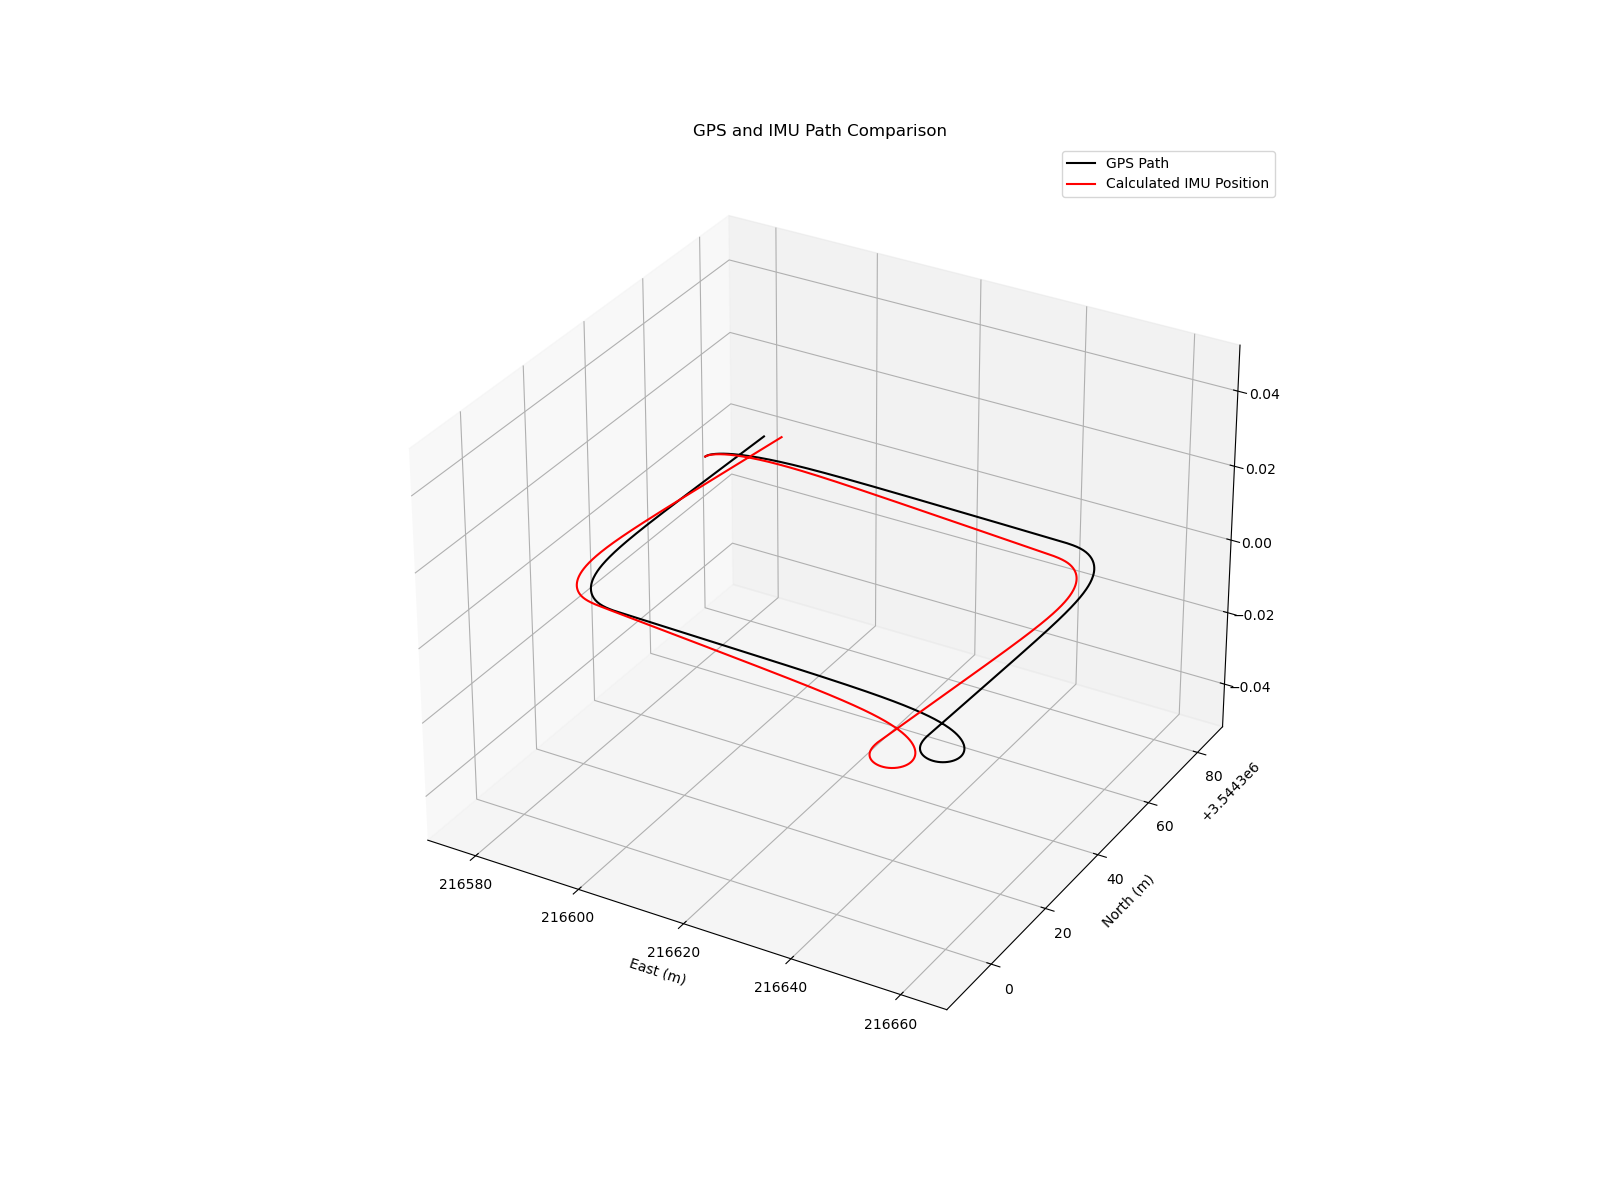

Average Acceleration Error: 0.000 m/s^2
Final Distance Away from True Position: -2.099 m
Noise Level: 0


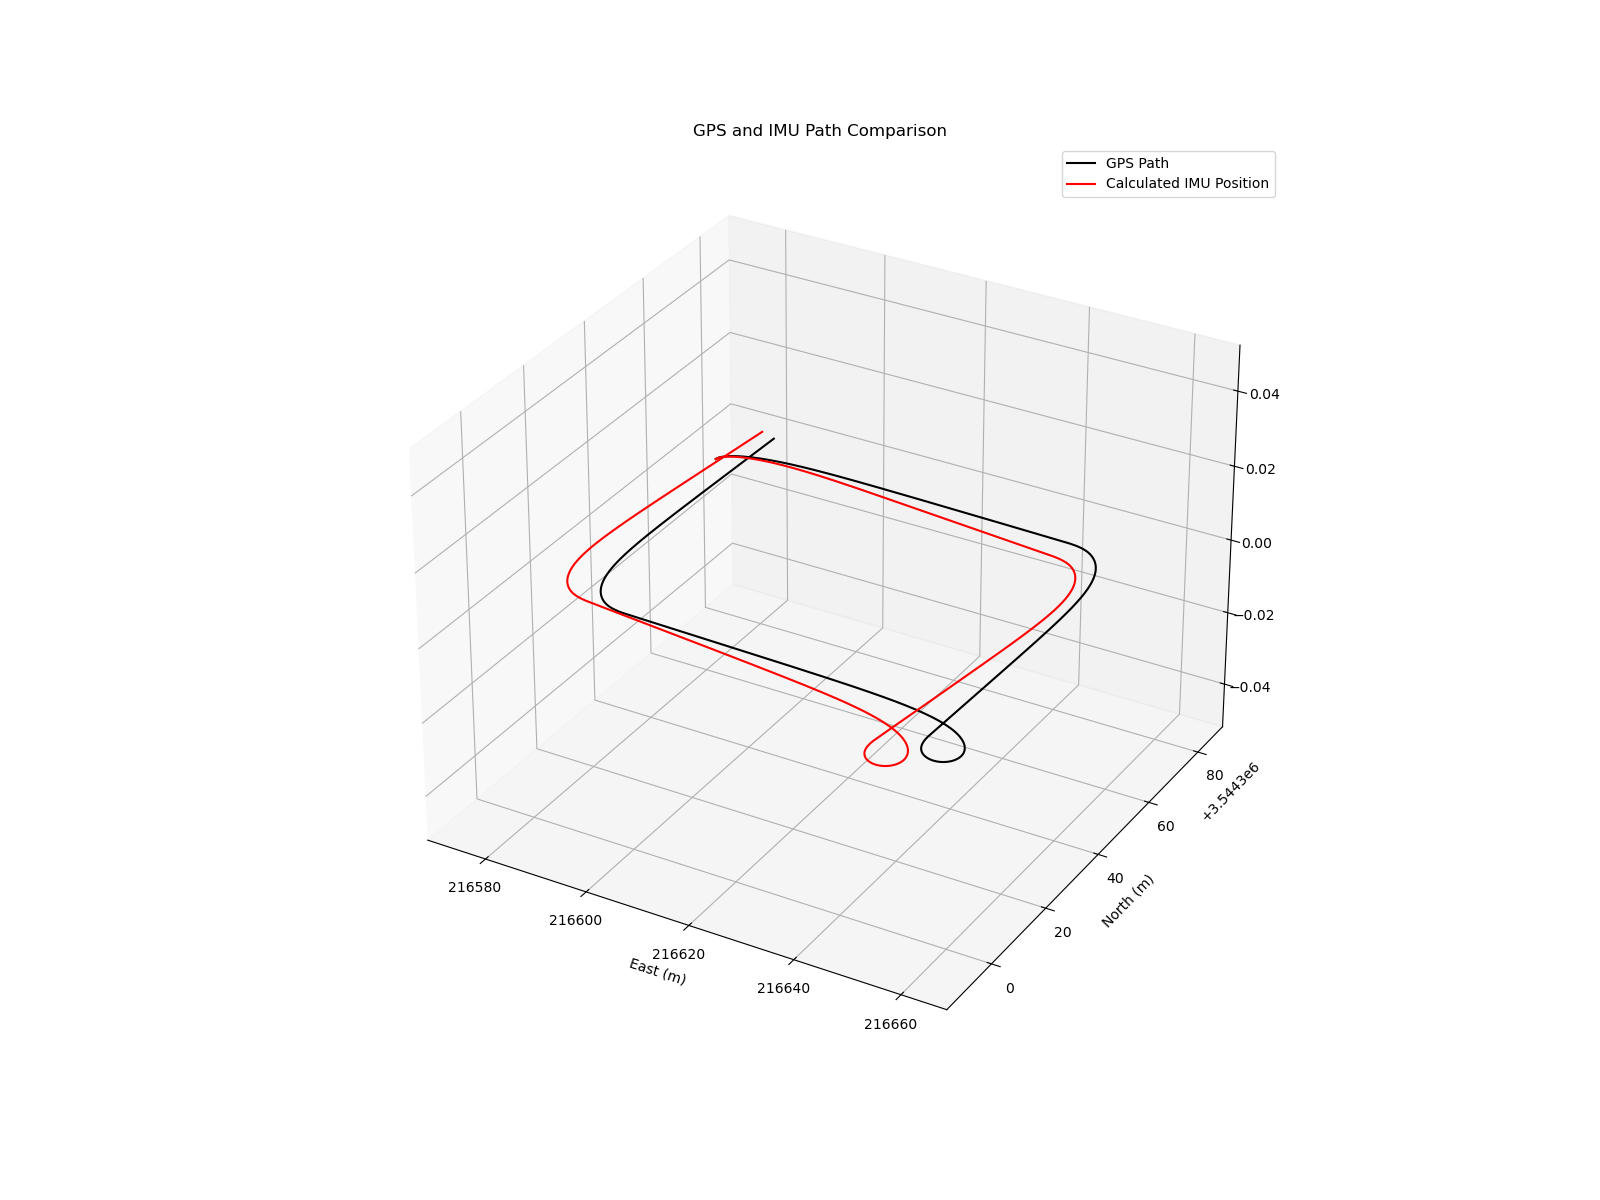

Average Acceleration Error: 0.040 m/s^2
Final Distance Away from True Position: 0.918 m
Noise Level: 0.05


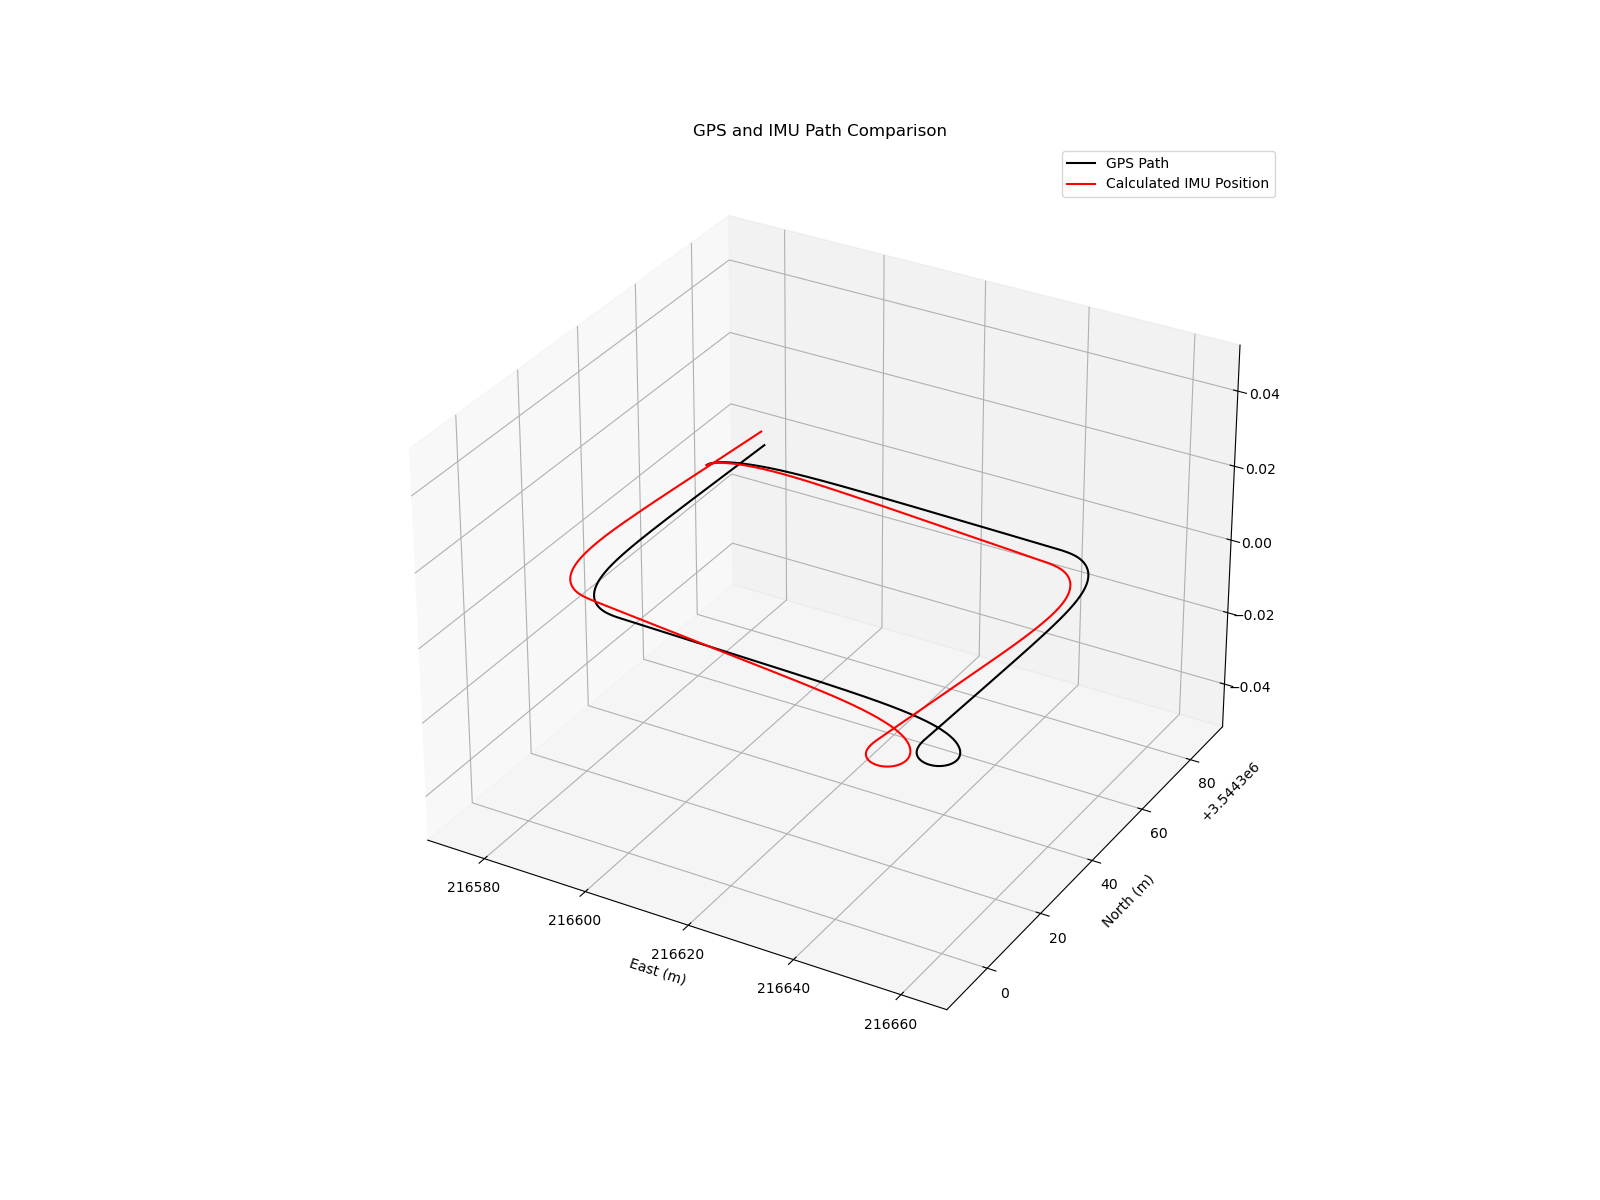

Average Acceleration Error: 0.120 m/s^2
Final Distance Away from True Position: -0.686 m
Noise Level: 0.15


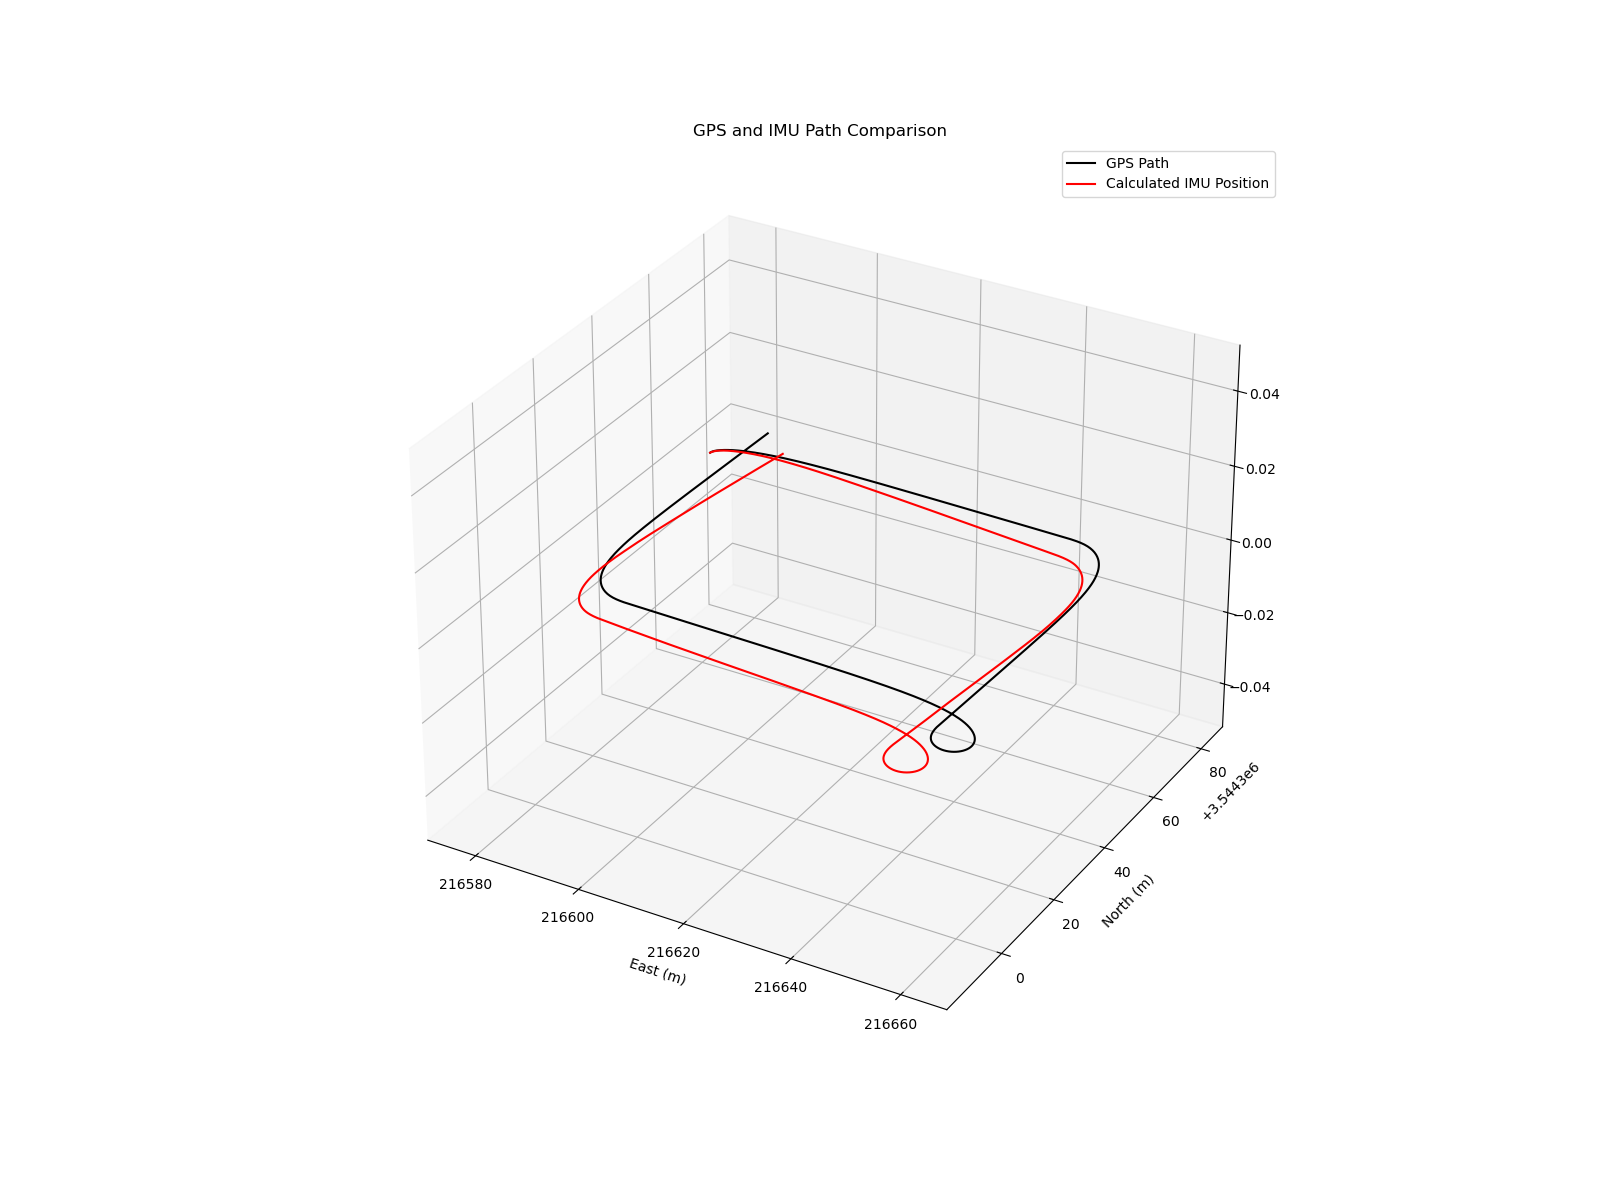

Average Acceleration Error: 0.198 m/s^2
Final Distance Away from True Position: -0.137 m
Noise Level: 0.25


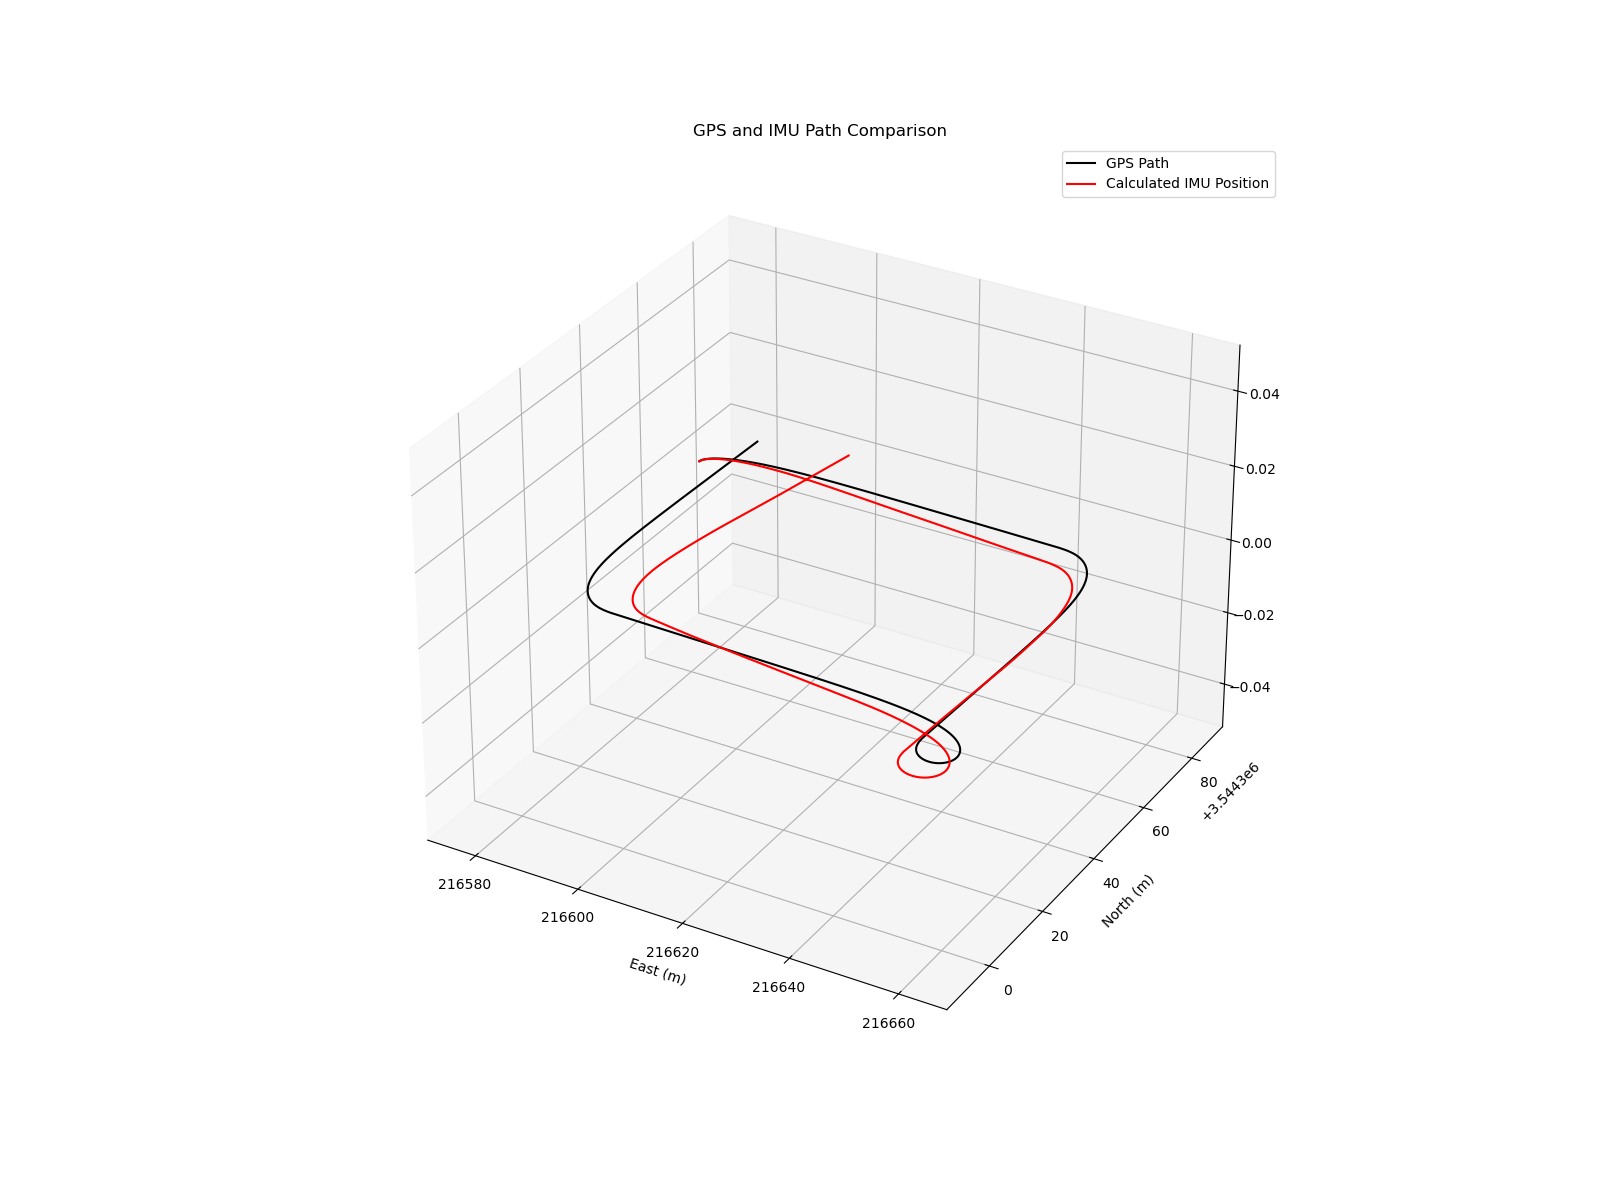

Average Acceleration Error: 0.282 m/s^2
Final Distance Away from True Position: -10.107 m
Noise Level: 0.35


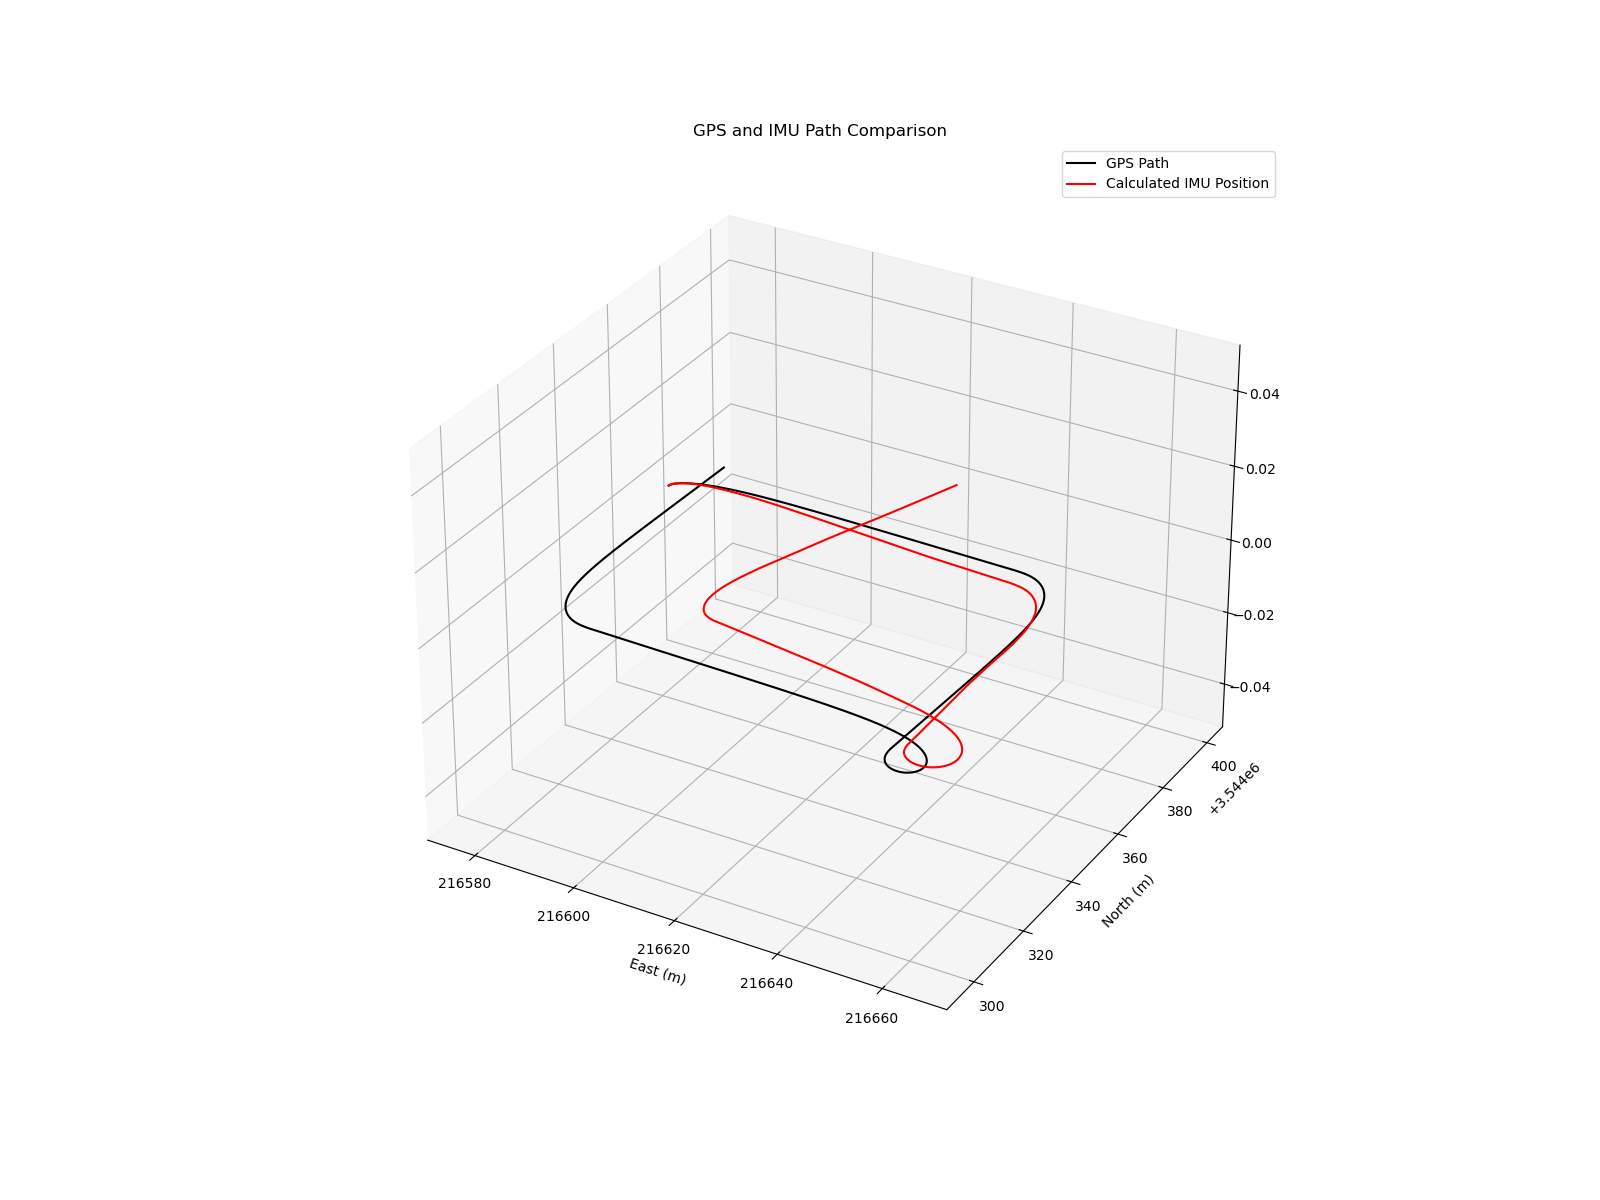

Average Acceleration Error: 0.400 m/s^2
Final Distance Away from True Position: -28.347 m
Noise Level: 0.5


In [57]:
noise_levels = [0, 0.05, 0.15, 0.25, 0.35, .5]

for noise_level in noise_levels:
    # Add noise to acceleration data and convert to numpy arrays
    noisy_accel_x = (accel_data['accel_x (m/s^2)'] + np.random.normal(0, noise_level, len(accel_data))).values
    noisy_accel_y = (accel_data['accel_y (m/s^2)'] + np.random.normal(0, noise_level, len(accel_data))).values
    noisy_accel_z = (accel_data['accel_z (m/s^2)'] + np.random.normal(0, noise_level, len(accel_data))).values

    # Combine noisy acceleration into a single numpy array
    noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y, noisy_accel_z))

    # Run Kalman filter and transform acceleration to NED frame
    filtered_accel_ned = run_kalman_filter_with_transformation(noisy_accel, mag_data, delta_t, var=noise_level**2)

    # Calculate positions with GPS update
    imu_positions_x, imu_positions_y = calculate_position_with_gps_update(filtered_accel_ned, gps_data, time_data['time (sec)'], gps_time_data['gps_time (sec)'], delta_t)

    # Plot data and print average error
    ref_gps_data = pd.read_csv('.//2023-11-17-15-11-06//ref_gps.csv')
    plot_data(imu_positions_x, imu_positions_y, ref_gps_data, noisy_accel_x, accel_data['accel_x (m/s^2)'])

    print(f"Noise Level: {noise_level}")

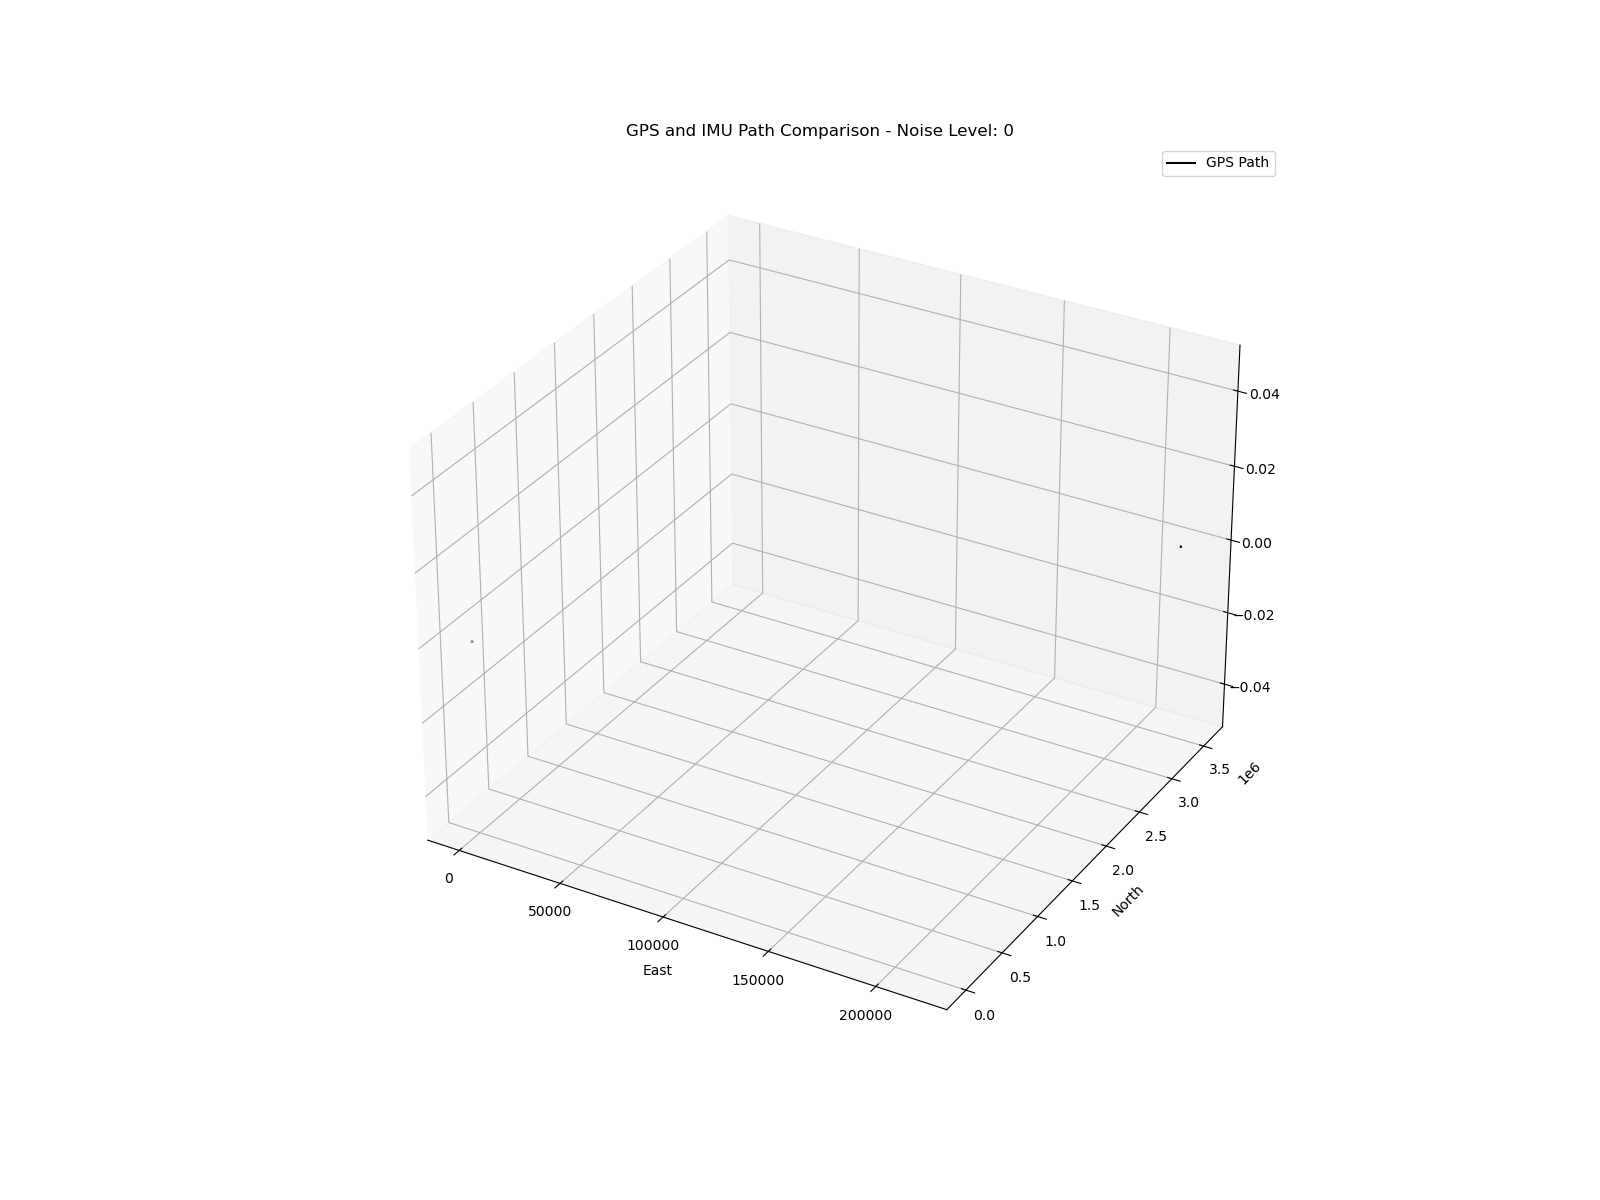

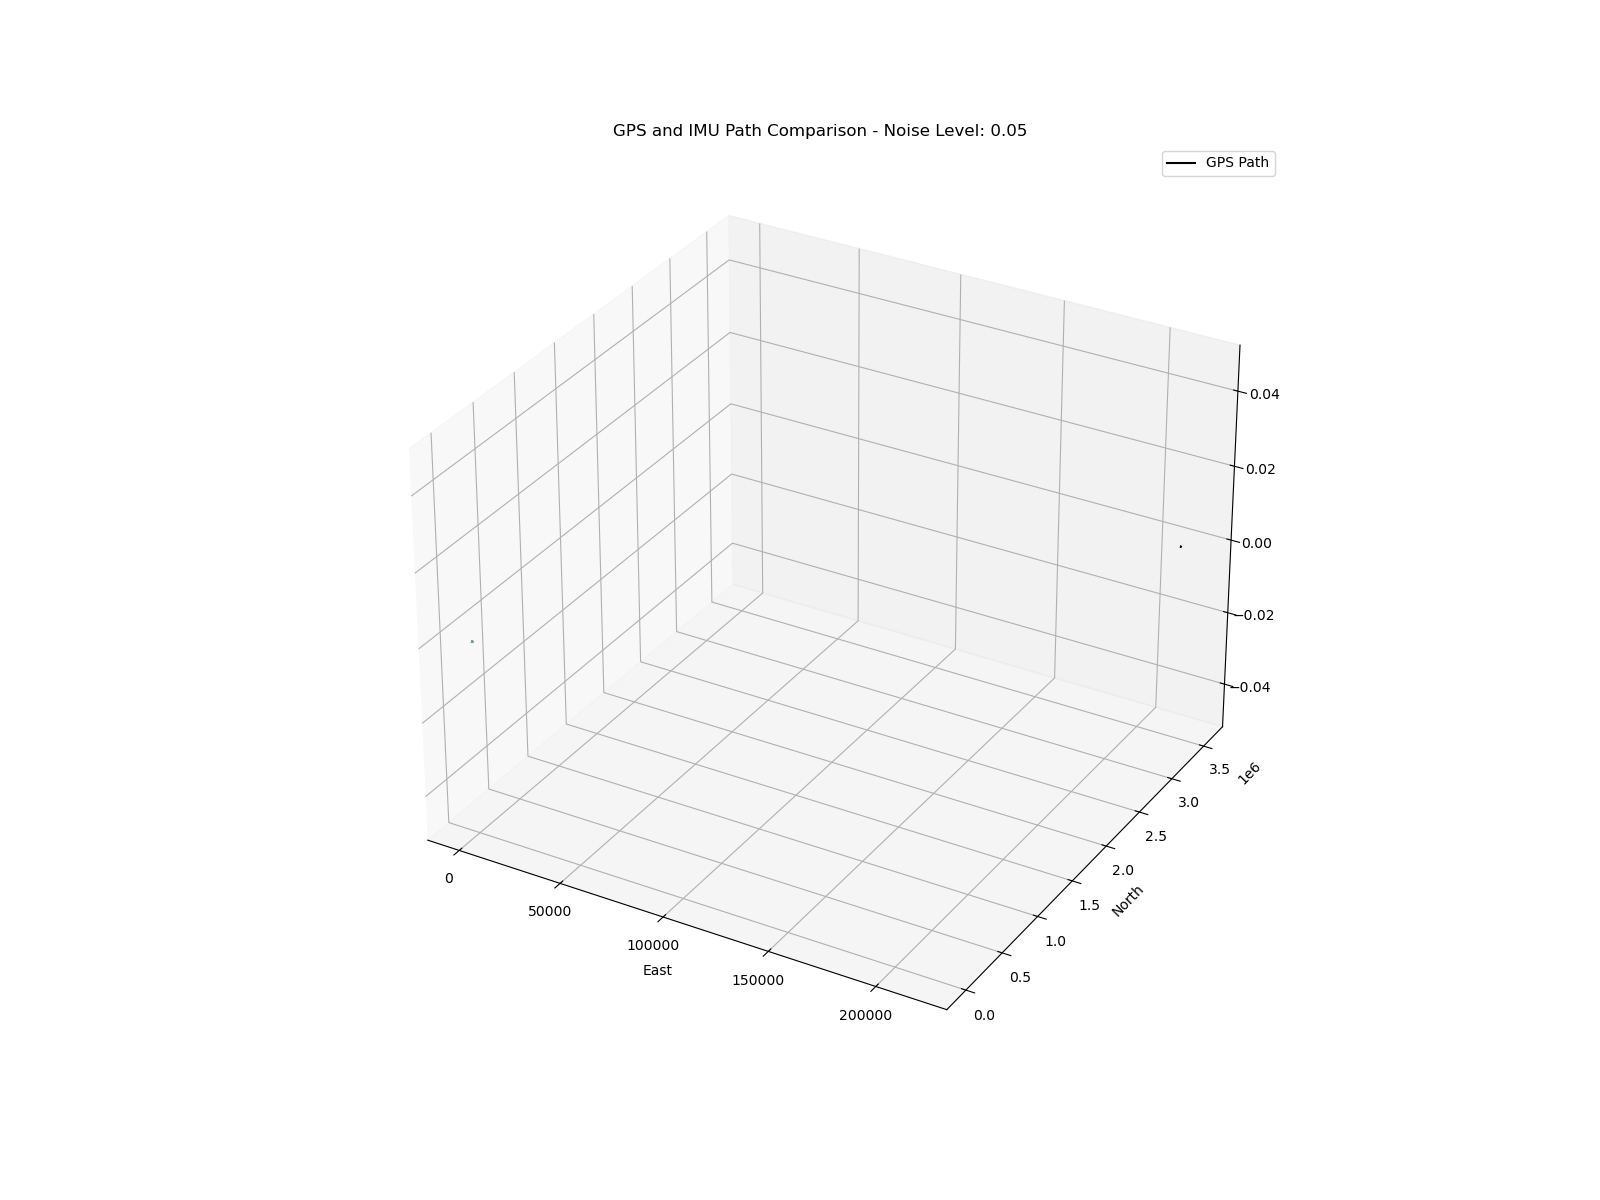

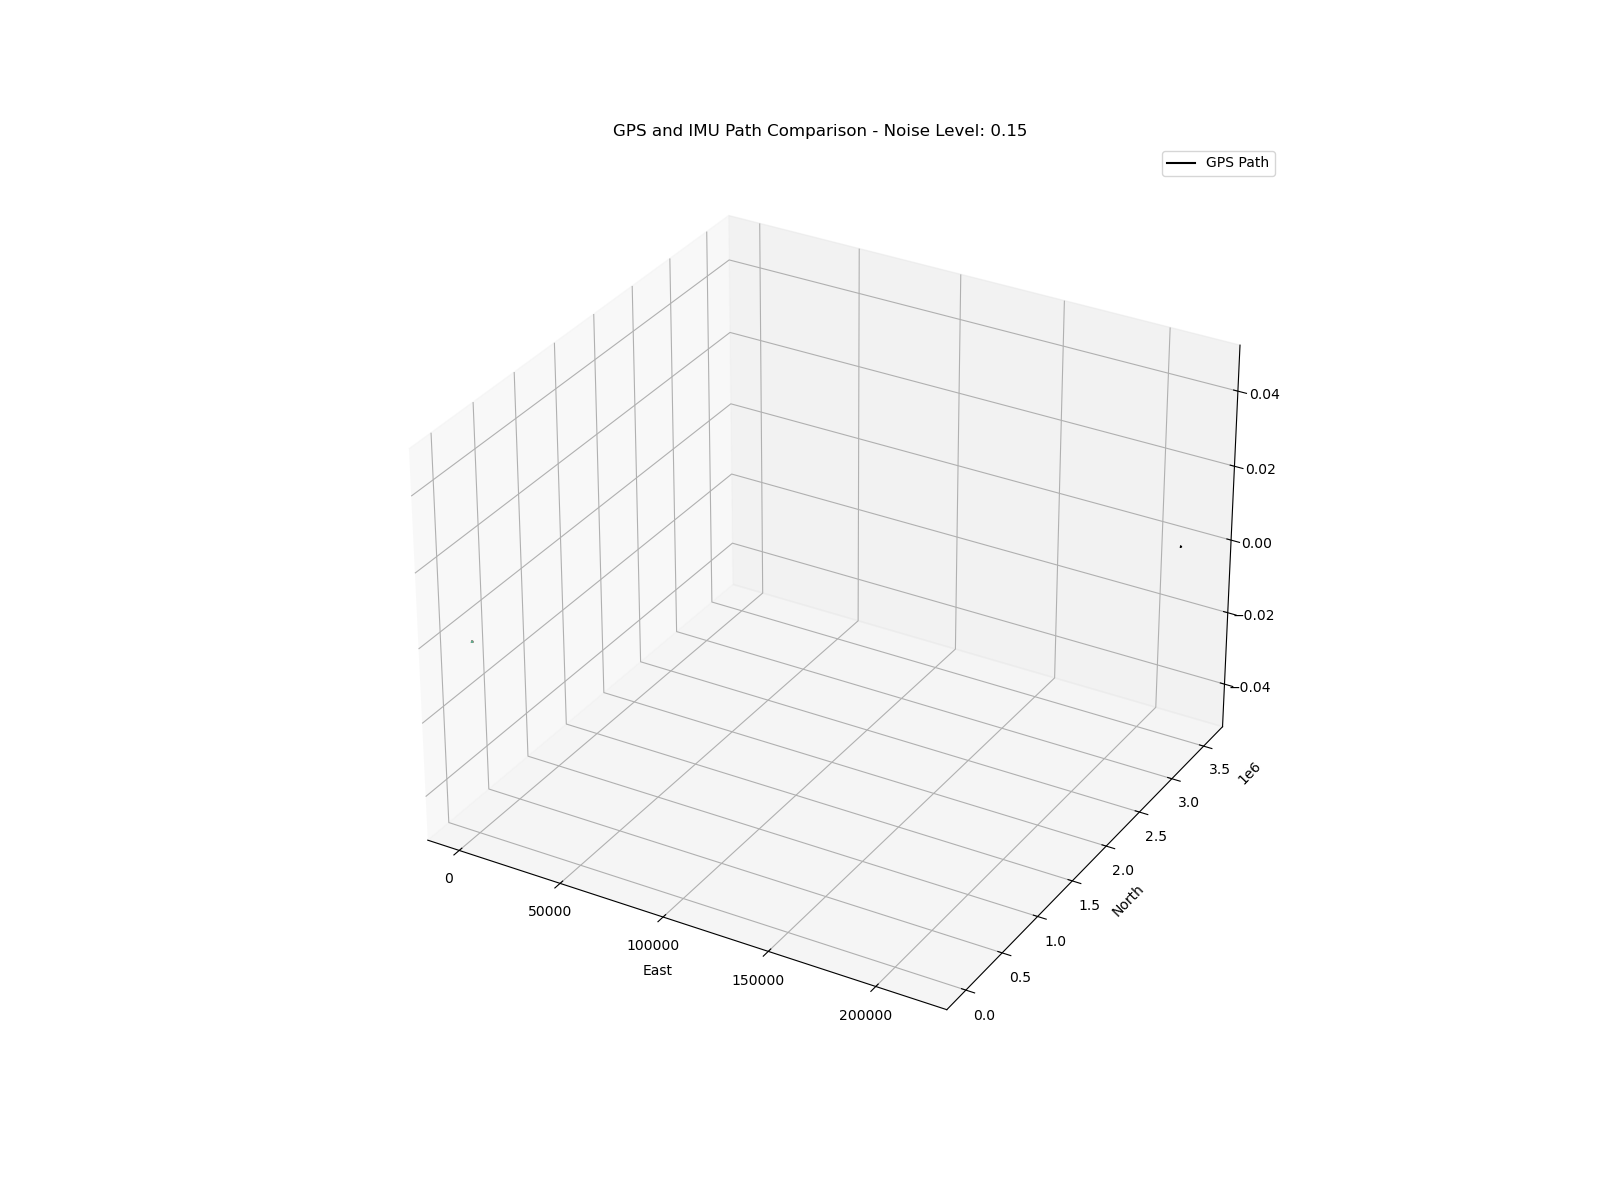

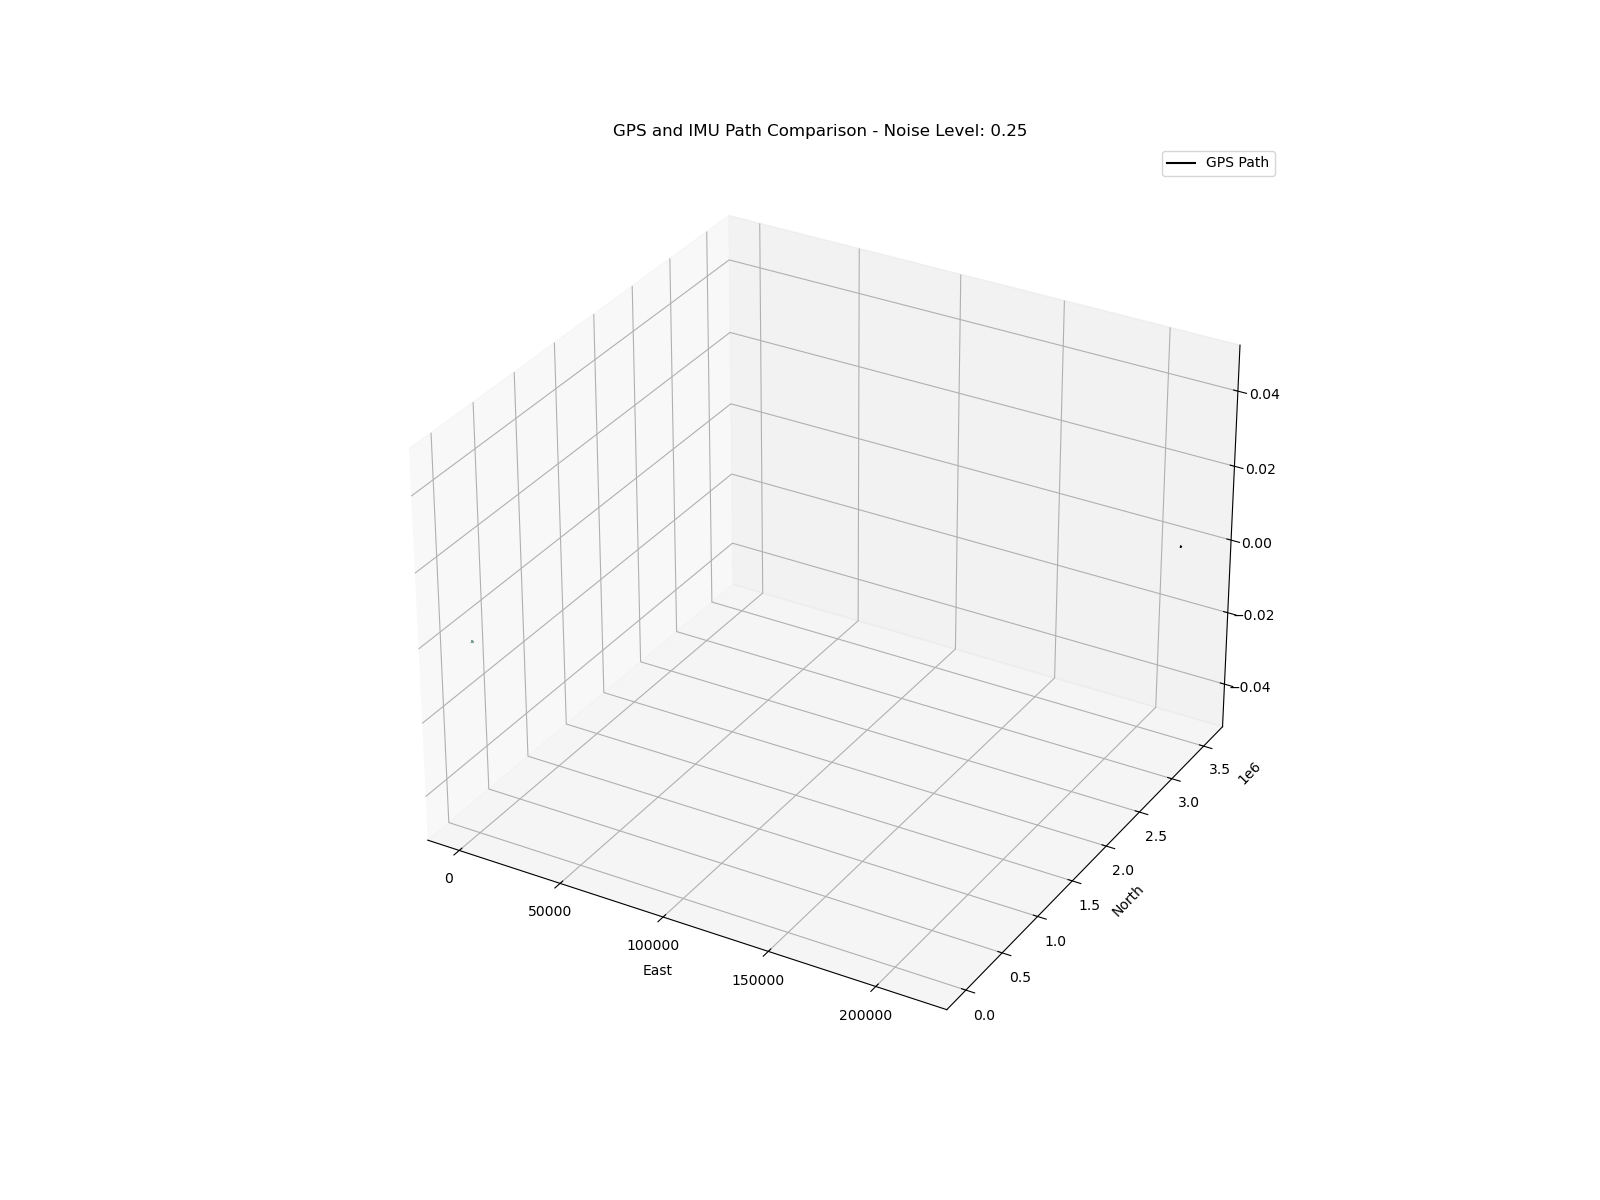

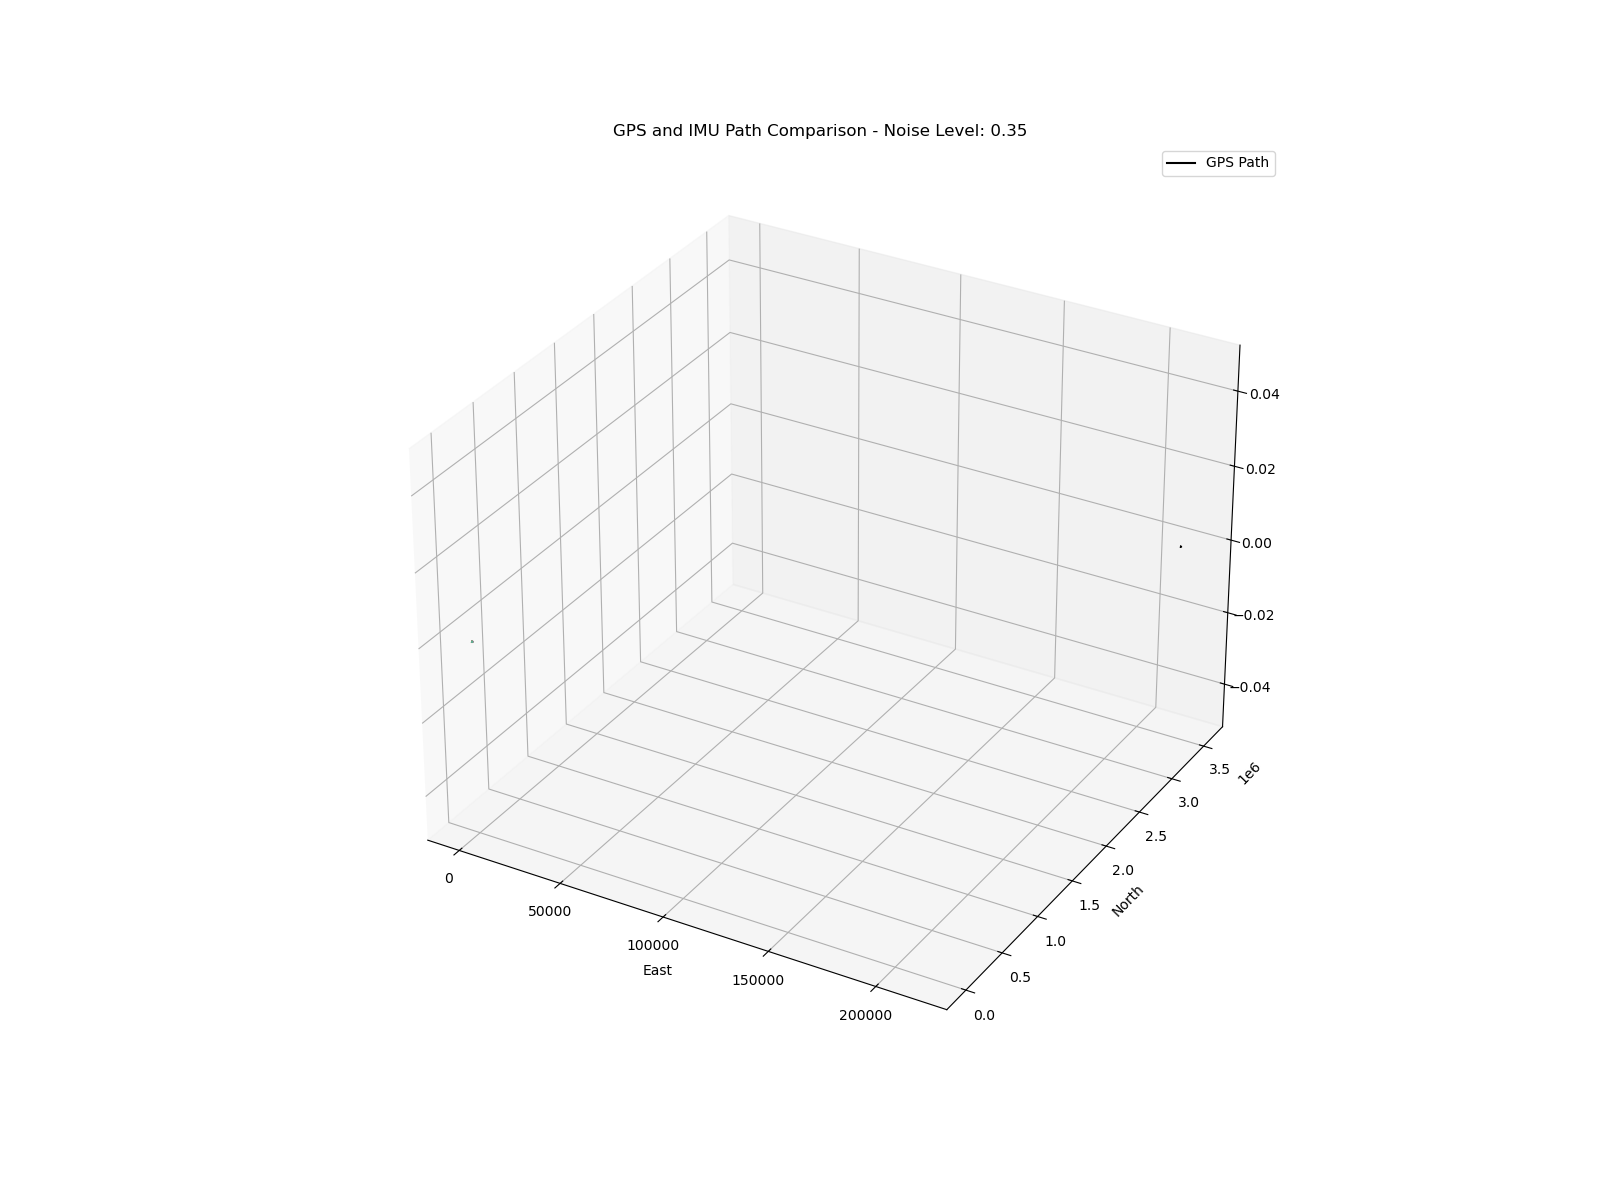

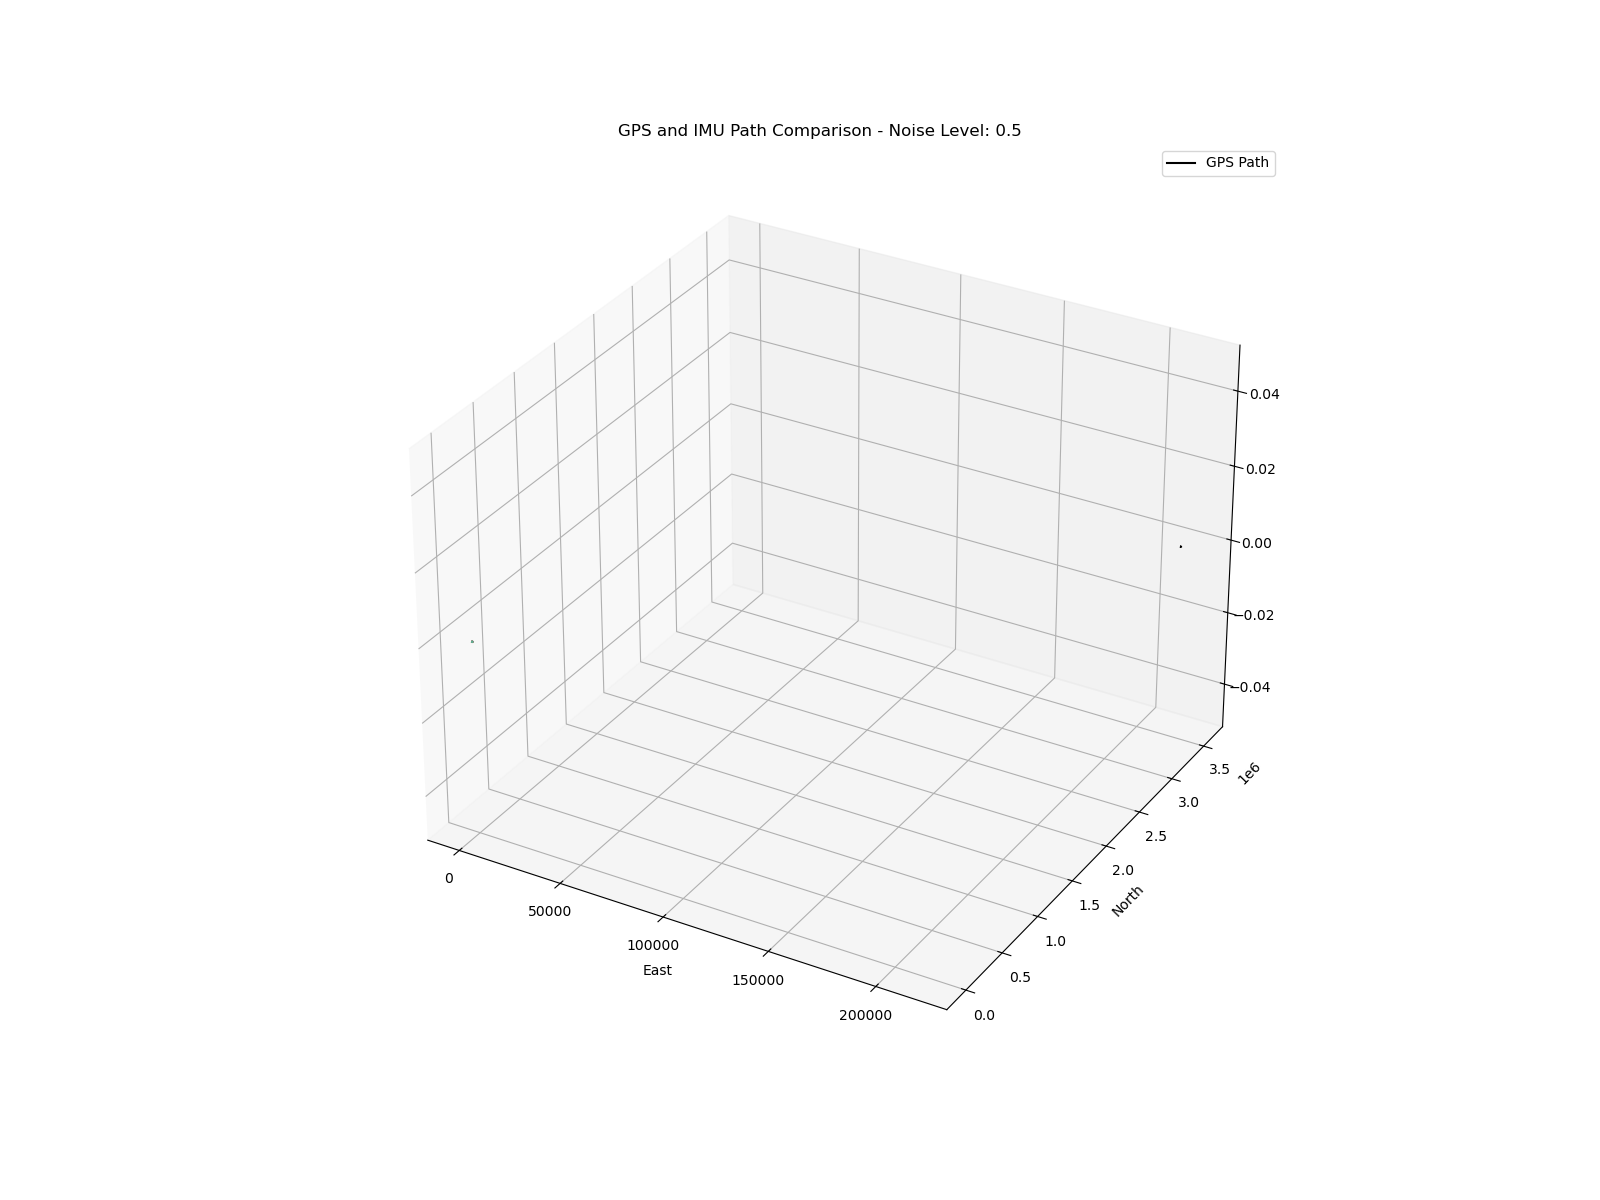

In [60]:
# Define number of trials
num_trials = 10

# Define noise levels
noise_levels = [0, 0.05, 0.15, 0.25, 0.35, .5]

# Loop for each noise level
for noise_level in noise_levels:
    plt.figure(figsize=(16, 12))
    plt.axes(projection='3d')

    # Perform trials for each noise level
    for trial in range(num_trials):
        # Add noise to acceleration data
        noisy_accel_x = (accel_data['accel_x (m/s^2)'] + np.random.normal(0, noise_level, len(accel_data))).values
        noisy_accel_y = (accel_data['accel_y (m/s^2)'] + np.random.normal(0, noise_level, len(accel_data))).values
        noisy_accel_z = (accel_data['accel_z (m/s^2)'] + np.random.normal(0, noise_level, len(accel_data))).values

        # Combine noisy acceleration into a single numpy array
        noisy_accel = np.column_stack((noisy_accel_x, noisy_accel_y, noisy_accel_z))

        # Process the noisy acceleration data
        filtered_accel_ned = run_kalman_filter_with_transformation(noisy_accel, mag_data, delta_t, var=noise_level**2)
        imu_positions_x, imu_positions_y = calculate_position_with_gps_update(filtered_accel_ned, gps_data, time_data['time (sec)'], gps_time_data['gps_time (sec)'], delta_t)

        # Convert GPS coordinates to UTM
        utm_coords = [utm.from_latlon(lat, lon) for lat, lon in zip(ref_gps_data['ref_gps_lat (deg)'], ref_gps_data['ref_gps_lon (deg)'])]
        utm_x, utm_y = np.array([coord[0] for coord in utm_coords]), np.array([coord[1] for coord in utm_coords])

        # Align IMU data with GPS origin
        origin_x, origin_y = utm_x[0], utm_y[0]
        imu_x_aligned, imu_y_aligned = imu_positions_x + origin_x, imu_positions_y + origin_y

        # Plot GPS and IMU data
        if trial == 0:
            plt.plot(utm_x, utm_y, label='GPS Path', linestyle='-', color='black')
        plt.plot(imu_positions_x, imu_positions_y, linestyle='-', alpha=0.5)

    plt.xlabel('East')
    plt.ylabel('North')
    plt.title(f'GPS and IMU Path Comparison - Noise Level: {noise_level}')
    plt.legend()
    plt.show()